In [28]:
import numpy as np
import os
import matplotlib.pyplot as plt

### Prediction

In [29]:
cwd = './results/shunqing/5s_res_bal_flood/'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = list(set(['_'.join(file.split('_')[:2]) for file in files]))

In [30]:
event = 'bpswmm_91'
r = np.load(os.path.join(cwd,event+'_runoff.npy'))
true = np.load(os.path.join(cwd,event+'_true.npy'))
pred = np.load(os.path.join(cwd,event+'_pred.npy'))
err = true - pred


In [31]:
event

'bpswmm_91'

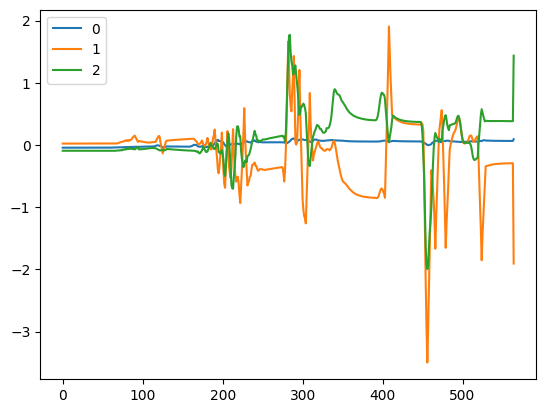

In [32]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
for i in range(3):
    plt.plot(err.mean(axis=1).mean(axis=1)[:,i],label=i)
    plt.legend()

Text(0.5, 1.0, 'Flooding')

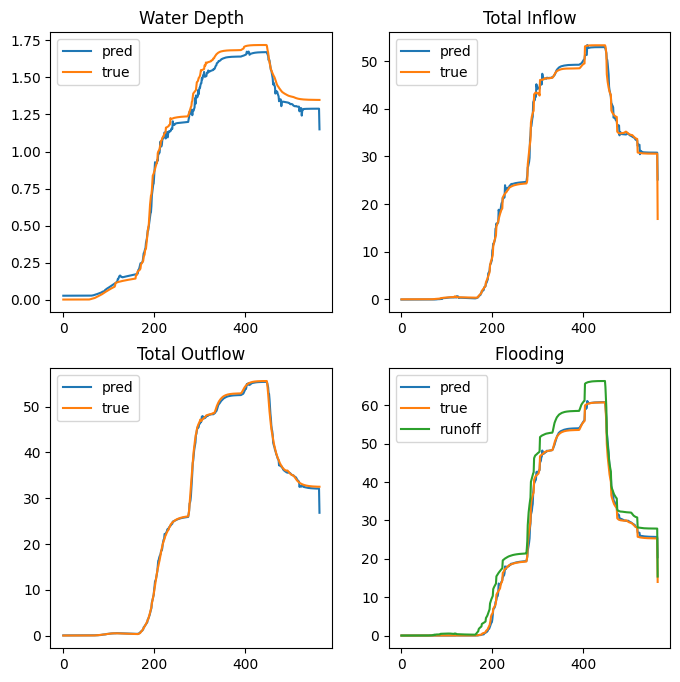

In [45]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
seq = -1

ax1.plot(pred[:,seq,...].mean(axis=1)[:,0],label='pred')
ax1.plot(true[:,seq,...].mean(axis=1)[:,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,...].mean(axis=1)[:,1],label='pred')
ax2.plot(true[:,seq,...].mean(axis=1)[:,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,...].mean(axis=1)[:,2],label='pred')
ax3.plot(true[:,seq,...].mean(axis=1)[:,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,...].mean(axis=1)[:,-1],label='pred')
ax4.plot(true[:,seq,...].mean(axis=1)[:,-1],label='true')
ax4.plot(r[:,seq,...].mean(axis=1),label='runoff')
ax4.legend()
ax4.set_title('Flooding')

- Select a Node to plot, what is the outlet boundary?
- Cannot predict water level of a specific node precisely
    - Possibly because it depends on both up and downstream
    - Or it can be better if nodes have storage volumes
- Cannot Predict flooding precisely
    - Classify flooding or not: It works!!!

In [34]:
from swmm_api import read_inp_file
inp = read_inp_file('./envs/network/shunqing/shunqing.inp')

Text(0.5, 1.0, 'Flooding')

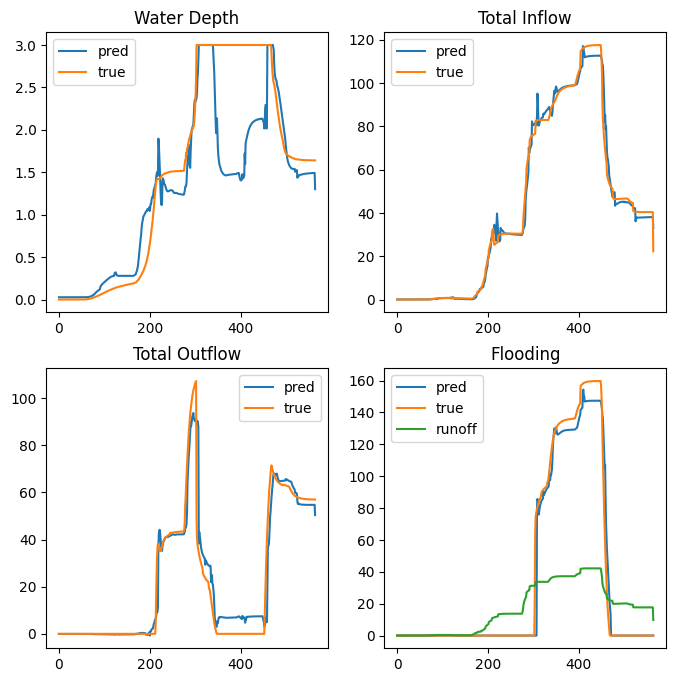

In [44]:
nodes = [k for k in inp.JUNCTIONS]
idx = nodes.index('jd55')
seq = -1

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

ax1.plot(pred[:,seq,idx,0],label='pred')
ax1.plot(true[:,seq,idx,0],label='true')
ax1.legend()
ax1.set_title('Water Depth')

ax2.plot(pred[:,seq,idx,1],label='pred')
ax2.plot(true[:,seq,idx,1],label='true')
ax2.legend()
ax2.set_title('Total Inflow')

ax3.plot(pred[:,seq,idx,2],label='pred')
ax3.plot(true[:,seq,idx,2],label='true')
ax3.legend()
ax3.set_title('Total Outflow')

ax4.plot(pred[:,seq,idx,-1],label='pred')
ax4.plot(true[:,seq,idx,-1],label='true')
ax4.plot(r[:,seq,idx,0],label='runoff')
ax4.legend()
ax4.set_title('Flooding')

In [ ]:
hmax = np.array([v.MaxDepth for _,v in inp.JUNCTIONS.items()])

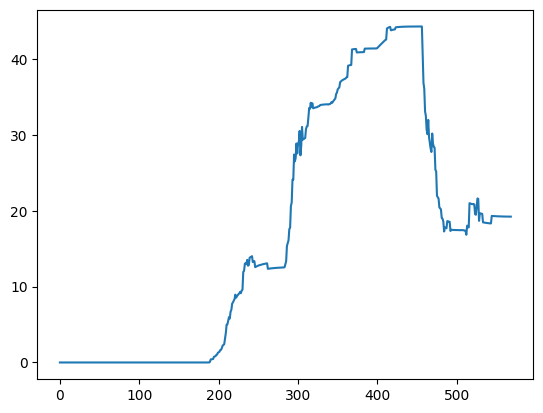

In [38]:
h,q_us,q_ds,q_w = [pred[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.1))[:,0,:].mean(axis=1))

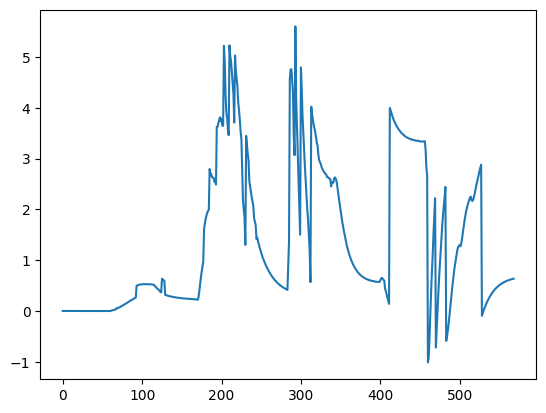

In [41]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot((q_us+r[...,-1]-q_ds-q_w)[:,0,:].mean(axis=1))

In [14]:
pred.shape

(569, 5, 105, 4)

In [17]:
hmax.shape

(105,)

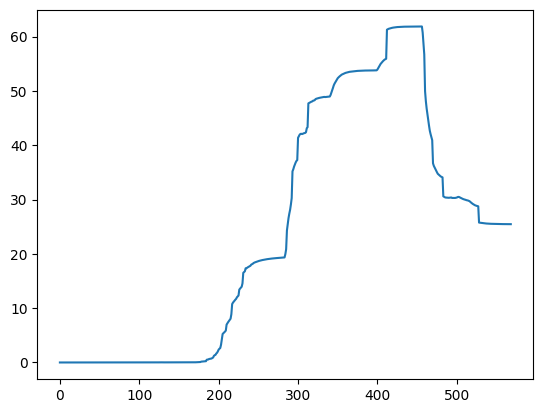

In [31]:
h,q_us,q_ds,q_w = [true[...,i] for i in range(4)]
plt.plot(((q_us + r[...,0] - q_ds).clip(0) * ((hmax-h)<0.01))[:,0,:].mean(axis=1))